#### 作品三：分類器評比 -- AT&T 人臉
##### 姓名：嚴潔翎
##### 學號：410878043
##### 目標：利用三份資料，比較不同分類器之表現，並觀察各別對資料做 PCA 後的分類結果，是優於或劣於原始資料。分類器包含三種：邏輯斯迴歸、支援向量機及神經網路。內部參數是決定分類器重要的螺絲，這些參數都能優化模型，使模型在所有訓練數據上的平均損失最小化，而此作品除了比較不同資料帶來的影響外，更透過調整內部參數，達到最佳的分類效果。

<hr>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from numpy.linalg import eig
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
plt.style.use('default')

In [3]:
def show_montage(X, n, m, h, w):
    '''
    X: 影 像 資 料 矩 陣 ， 每 行 代 表 一 張 影 像
    n, m: 每 張 影 像 的 大 小 n x m
    h, w : 建 立 一 個 蒙 太 奇 圖 陣 ， 大小 figsize = (w,h)
    '''
    fig, axes = plt.subplots(h, w, figsize=(w*2, h*2))
    if X.shape[1] < w * h: # 影 像 張 數 不 到 w x h 張 ， 用 0 向量補齊
        X = np.c_[X, np.zeros((X.shape[0], w*h-X.shape[1]))]
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[:,i].reshape(m, n), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Prepare data

【資料簡述】此資料來自劍橋大學 AT&T 實驗室採集的人臉數據，共 400 張圖，包含 40 個人，每人 10 張圖，分別從不同角度拍攝，每張圖片大小 64 $\times$ 64。

【分類方法】
1. Logistic Regression
2. SVM
3. Neural Network


【資料處理】
1. 切割資料集：將資料集以 3 : 1 ( 75 % : 25 % ) 分成訓練集、測試集，
2. 標準化：分別對訓練集、測試集標準化，避免因單位不同、數值大小差距過大而造成的分析錯誤。
3. 主成分分析：比較使用「原始資料」與「PCA 後萃取出的資訊」的差異。


# AT&T

photo size:  64 x 64
# of distinct subjects:  40


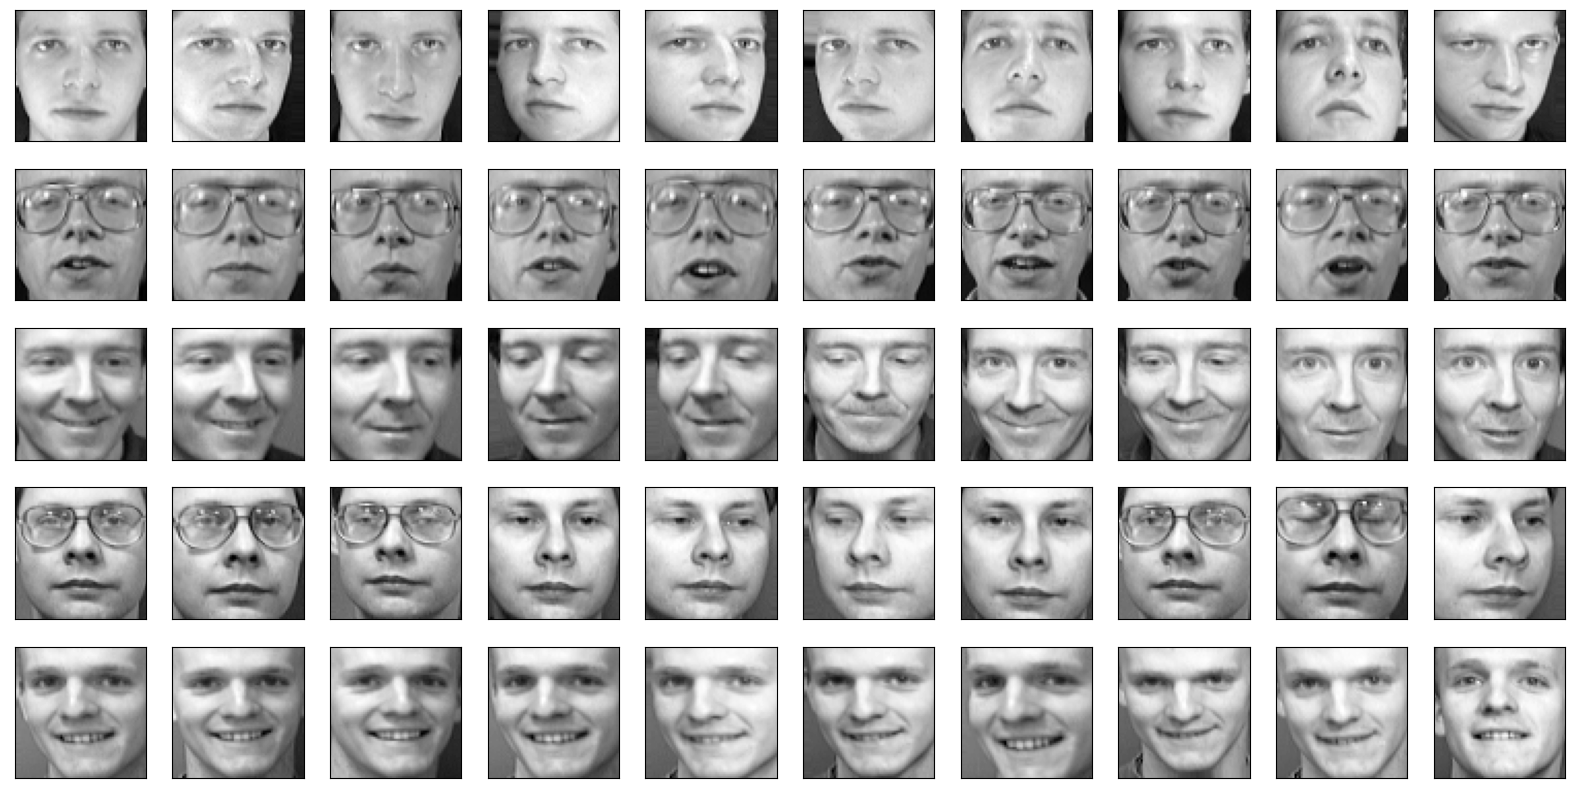

In [4]:
# AT&T faces
atnt = pd.read_csv('face_data.csv', encoding = 'U8')
n_persons = atnt['target'].nunique()
X = np.array(atnt.drop('target', axis = 1))
y = np.array(atnt['target'])

n, m = 64, 64

print('photo size: ', int(np.sqrt(X.shape[1])), 'x', int(np.sqrt(X.shape[1])))
print('# of distinct subjects: ', n_persons)
show_montage(X.T, n, m, 5, 10)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3)
# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

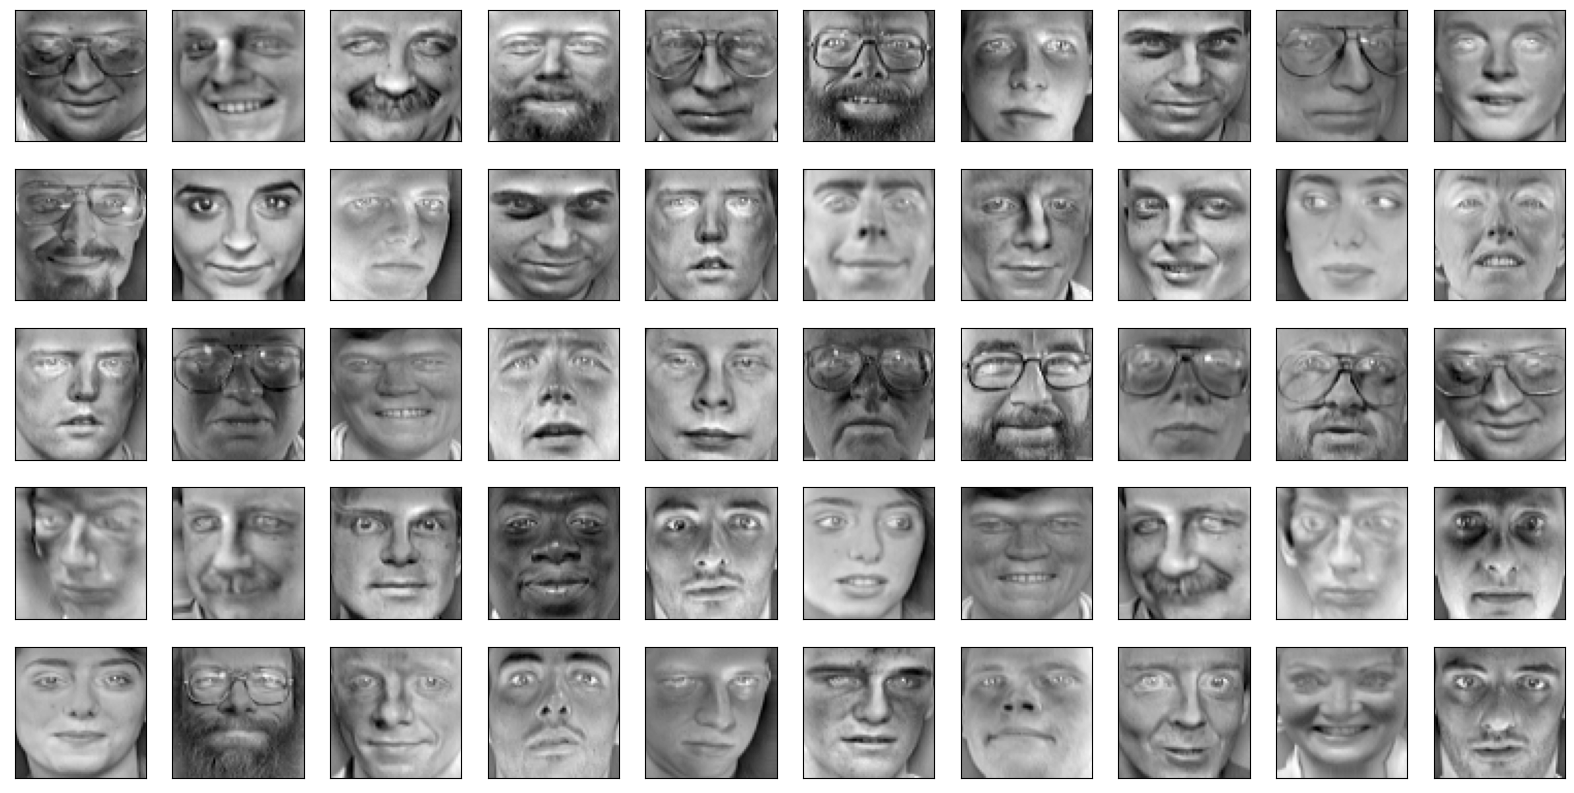

In [94]:
show_montage(X_train_.T, n, m, 5, 10)

In [ ]:
Sx = np.cov(X_train_.T, bias = False)
w, v = eig(Sx)
idx = np.argsort(w)[::-1]
eigvals = w[idx]
eigvecs = v[:, idx] 
Sigma_x = eigvecs @ np.diag(eigvals) @ eigvecs.T

C:\Users\jenny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Scree plot')

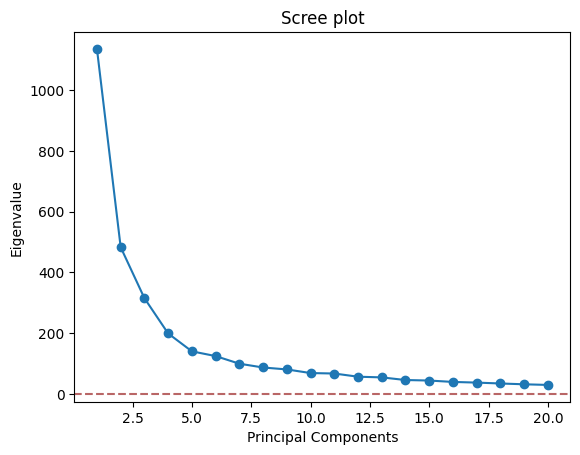

In [ ]:
x = np.arange(1, 20+1)
plt.plot(x, eigvals[0:20], marker='o')
plt.axhline(1, c = 'darkred', ls = '--', alpha = 0.6)
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalue')
plt.title('Scree plot')
# plt.xlim(0, 20)

In [31]:
pca = PCA(n_components = 15).fit(X_train_)   # 280 -> 15
Z_train = pca.transform(X_train_)   # Apply dimensionality reduction to X.
Z_test = pca.transform(X_test_)
# -------------------------------------
explained = np.round(pca.explained_variance_ratio_*100, 2)
print('Explained variance ratio: {}%'.format("%, ".join(str(x) for x in explained)))
print('Cummulative variance explained : {:.2%}'.format(round(sum(pca.explained_variance_ratio_), 4)))

Explained variance ratio: 28.85%, 12.01%, 7.96%, 4.33%, 3.3%, 3.19%, 2.44%, 2.02%, 1.81%, 1.69%, 1.34%, 1.29%, 1.21%, 1.18%, 1.09%
Cummulative variance explained : 73.70%


將標準化後訓練集資料作主成分分析，並取前 15 個主成分，這些主成分能解釋 73.7% 的總變異量，從原本的 280 個變數縮減成 15 個變數。
雖然從第五個主成分後的差異就不大，若只取前 5 / 10 個，訓練出來的效果會非常差，故仍取前 15 個主成分。
<hr>

## 邏輯斯迴歸

【參數調整】solver
- lbfgs
- liblinear
- newton-cg

【參與資料】
- 原始資料
- 標準化資料
- PCA 資料

In [8]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose = 0)
df = pd.DataFrame()
for sol in ['lbfgs','liblinear','newton-cg']:
    start = time.time()

    clf_LR_original = LogisticRegression(solver = sol, **opts)    
    clf_LR_original.fit(X_train_, y_train)                           
    y_pred = clf_LR_original.predict(X_test_)  

    end = time.time()
    temp = pd.DataFrame(data = {'Method':['Logistic'], 'Acc':[round(clf_LR_original.score(X_test_, y_test), 2)],\
                        'Time':[(end - start)], 'Parameter':[sol]})
    df = pd.concat([df, temp], ignore_index = True)

df

,Method,Acc,Time,Parameter
0,Logistic,0.95,46.529048,lbfgs
1,Logistic,0.89,73.919791,liblinear
2,Logistic,0.95,21.774489,newton-cg


以此資料來看，newton-cg 是最佳的演算法，準確率高、運行時間是擁有相同準確率的 lbfgs 的一半，故選擇 newton-cg 當作學習器的 solver。

【Solver】
newton-cg 特點：
- 遇到多組分類時，能較好的處理多類別的損失 (multinomial loss)。
- 利用二次近似 (quadratic apprximation) 執行兩次偏微，將損失函數 (Loss function) 最小化。

<font size = 4>【註】參數值與偏誤的為鐘型關係，也就是損失函數，為一個二次式。[solvers](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions)
</font>

### 標準化資料

In [12]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=1)
sol = 'newton-cg'
clf_LR_original = LogisticRegression(solver = sol, **opts)    # define learner
clf_LR_original.fit(X_train_, y_train)                           # start training, learned
y_pred = clf_LR_original.predict(X_test_)  

print(f"{clf_LR_original.score(X_test_, y_test):.2%}\n")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


95.00%



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s finished


### PCA 資料

In [111]:
opts = dict(tol = 1e-6, max_iter = int(1e6), verbose=1)
sol = 'newton-cg'
clf_LR_original = LogisticRegression(solver = sol, **opts)    # define learner
clf_LR_original.fit(Z_train, y_train)                           # start training, learned
y_pred = clf_LR_original.predict(Z_test)  

print(f"{clf_LR_original.score(Z_test, y_test):.2%}\n")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


93.33%



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


【討論】
準確率：
- 標準化資料：95%
- PCA：93%

兩者差距並不大，但 PCA 資料所需時間甚至不用一秒，卻只差了 2% 準確率，可以說是分類結果是相當好。

<hr>

## SVM

【參數組合】
- kernel: linear, rbf, poly, sigmoid，共四種
- gamma: scale, auto，共兩種
- decision_function_shape: ovo, ovr，共兩種

【參與資料】
- 標準化
- PCA


In [11]:
para = {'kernel':('linear','rbf','poly','sigmoid'), 'gamma':('scale','auto'), \
    'decision_function_shape':('ovo','ovr')}
svc = SVC(tol = 1e-6, max_iter = int(1e6))
clf = GridSearchCV(svc, para)   # default: 5-fold
clf.fit(X_train_, y_train)
# clf.cv_results_
print(f"# of folds: {clf.n_splits_}")
print(f"Mean cross-validated score of the best_estimator: {clf.best_score_:.2%}")
print(f"best combination: {clf.best_params_}", end = "\n\n")

C:\Users\jenny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


# of folds: 5
Mean cross-validated score of the best_estimator: 95.00%
best combination: {'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear'}



【討論】最佳參數組合：
- kernel: linear
- gamma: scale
- decision_function_shape: ovo

根據 GridSearchCV 結果顯示，最佳的核函數為線性，而Gamma 是針對非線性 SVM 所設定的超參數，但此指令會將所有參數組合在一起，無論實際上是否合理，並將線性的核函數配了一個不存在的 gamma，故在後面的分類器沒有放入。

### 標準化資料

In [48]:
%%time
# standardized
opts = dict(decision_function_shape = 'ovo', \
               tol = 1e-6, max_iter = int(1e6))
clf_svm_ori = SVC(kernel = "linear", **opts)     
clf_svm_ori.fit(X_train_, y_train)
predictions = clf_svm_ori.predict(X_test_)
print(f"{clf_svm_ori.score(X_test_, y_test):.2%}\n")   


91.67%

CPU times: total: 312 ms
Wall time: 356 ms


### PCA 資料

In [112]:
%%time
# pca
opts = dict(decision_function_shape = 'ovo', \
               tol = 1e-6, max_iter = int(1e6))
clf_svm_pca = SVC(kernel = "linear", **opts)     
clf_svm_pca.fit(Z_train, y_train)
predictions = clf_svm_pca.predict(Z_test)
print(f"{clf_svm_pca.score(Z_test, y_test):.2%}\n")   # test score


90.00%

CPU times: total: 46.9 ms
Wall time: 46.7 ms


【討論】

雖然準確率不及羅吉斯迴歸，但其速度快上許多，都只需要毫秒的時間就能完成，且標準化資料與 PCA 資料差別不大，或許 SVM 更適合這份資料。

<hr>

## Neural Network

【參數組合】
- solver: lbfgs, sgd, adam
- activation: identity, relu, logistic
- hidden layer: (20, ), (50, ), (80, ), (100, ), (40, 40), (50, 50)

【參與資料】
- 標準化
- PCA

In [ ]:
para = {'solver':('lbfgs','sgd','adam'), 'activation':('identity','logistic','relu'), \
    'hidden_layer_sizes':((20,), (50,), (80,), (100,), (40, 40), (50, 50))}
mlp = MLPClassifier(tol = 1e-6, max_iter = int(1e6))
clf_mlp = GridSearchCV(mlp, para)   # default: 5-fold
clf_mlp.fit(X_train_, y_train)
# 653 mins

In [ ]:
para = {'solver':('lbfgs','sgd','adam'), 'activation':('identity','logistic','relu'), \
    'hidden_layer_sizes':((20,), (50,), (80,), (100,), (40, 40), (50, 50))}
mlp = MLPClassifier(tol = 1e-6, max_iter = int(1e6))
clf_mlp_rand = RandomizedSearchCV(mlp, para)   # default: 5-fold
clf_mlp_rand.fit(X_train_, y_train)
# 44 mins

In [86]:
print(f'   [Grid]    best parameter combination: {clf_mlp.best_params_}')
print(f'[Randomized] best parameter combination: {clf_mlp_rand.best_params_}')

   [Grid]    best parameter combination: {'activation': 'logistic', 'hidden_layer_sizes': (80,), 'solver': 'sgd'}
[Randomized] best parameter combination: {'solver': 'lbfgs', 'hidden_layer_sizes': (40, 40), 'activation': 'logistic'}


【討論】

- Grid:
    - activation: logistic
    - solver: sgd
    - hidden_layer_sizes: (80, )   
<br>
- Randomized:
    - activation: logistic
    - solver: lbfgs
    - hidden_layer_sizes: (40, 40)


分別利用 GridSearch, RandomizedSearch 尋找最佳參數組合。先談花費時間，GridSearchCV 花了 653 分鐘，而 RandomizedSearchCV 只花了 44 分鐘，一個需要將近 11 小時，一個一小時不到，論時間成本都是 RandomizedSearch 大勝，不過也要測試看看此方法提供的最佳參數組合是否能很好的分類。


#### GridSearchCV

1. 標準化資料
2. PCA 資料

In [17]:
# grid search result
hidden_layers = (80,)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, \
        activation = activation, tol = 1e-6, max_iter = int(1e6))
solver = 'sgd'

# standardized
start_gs = time.time()
clf_MLP_ori = MLPClassifier(solver = solver, **opts)
clf_MLP_ori.fit(X_train_, y_train)
pred_MLP_ori = clf_MLP_ori.predict(X_test_)
end_gs = time.time()

# pca
start_gp = time.time()
clf_MLP_pca = MLPClassifier(solver = solver, **opts)
clf_MLP_pca.fit(Z_train, y_train)
pred_MLP_pca = clf_MLP_pca.predict(Z_test)
end_gp = time.time()

#### RandomizedSearchCV

1. 標準化資料
2. PCA 資料

In [19]:
# rand search result
hidden_layers = (40, 40)
activation = 'logistic'
opts = dict(hidden_layer_sizes = hidden_layers, \
        activation = activation, tol = 1e-6, max_iter = int(1e6))
solver = 'lbfgs'

# standardized
start_rs = time.time()
clf_MLP_ori_rand = MLPClassifier(solver = solver, **opts)
clf_MLP_ori_rand.fit(X_train_, y_train)
pred_MLP_ori_rand = clf_MLP_ori_rand.predict(X_test_)
end_rs = time.time()

# pca
start_rp = time.time()
clf_MLP_pca_rand = MLPClassifier(solver = solver, **opts)
clf_MLP_pca_rand.fit(Z_train, y_train)
pred_MLP_pca_rand = clf_MLP_pca_rand.predict(Z_test)
end_rp = time.time()

In [44]:
gs = round(clf_MLP_ori.score(X_test_, y_test), 4)
gp = round(clf_MLP_pca.score(Z_test, y_test), 4)
rs = round(clf_MLP_ori_rand.score(X_test_, y_test), 4)
rp = round(clf_MLP_pca_rand.score(Z_test, y_test), 4)
gs_time = end_gs - start_gs
gp_time = end_gp - start_gp
rs_time = end_rs - start_rs
rp_time = end_rp - start_rp

pd.DataFrame(data = {'SearchCV':['Grid','Grid','Randomized','Randomized'],\
                     'Solver':['sgd','sgd','lbfgs','lbfgs'],\
                     'Hidden layer':['(80,)','(80,)','(40, 40)','(40, 40)'],\
                     'Data type':['Standardized','PCA','Standardized','PCA'],\
                     'Accuracy':[gs, gp, rs, rp],\
                     'Time (sec.)':[gs_time, gp_time, rs_time, rp_time]}) 

,SearchCV,Solver,Hidden layer,Data type,Accuracy,Time (sec.)
0,Grid,sgd,"(80,)",Standardized,0.9750,660.476884
1,Grid,sgd,"(80,)",PCA,0.9250,59.894088
2,Randomized,lbfgs,"(40, 40)",Standardized,0.9333,8.864544
3,Randomized,lbfgs,"(40, 40)",PCA,0.8500,3.832411


【討論】

與任何分類器結果相同，主成分分析資料的準確率都低於標準化的原始資料，故不多做討論。

在深入探討前，先了解 sgd 及 lbfgs 兩個演算法。[INFO](https://www.cs.tufts.edu/comp/135/2020f/hw3.html)


##### 隨機梯度下降 (Stochastic Gradient Descent, SGD) 

每次迭代：
- 利用梯度 (一階導數) 的資訊來更新參數。
- 從訓練集裡**隨機抽取批次** (batch) 來**估計**梯度。


##### Limited-memory BFGS (L-BFGS)
每次迭代：
- 利用一階導數、二階導數的資訊來更新參數。
- 使用**整個**訓練集**計算**梯度。

<font size = 4>【註】使用二階導數的方法是受到牛頓法 (Newton's method) 的啟發，故稱「擬牛頓 (quasi-Newton)」</font>

從上面的簡介來看，L-BFGS 所需時間較 SGD 短，與結果相符，因為 L-BFGS 使用較多的資訊 (一階及二階導數)，並使用整個訓練及資料去計算梯度，而 SGD 只使用一階導數，且要隨機抽取批次，就會花更多時間。

L-BFGS + 標準化資料的準確度達 93%，雖然與 SGD 的 97% 無法相比，但在時間長度比較下，這個演算法堪用，且能使用較多資訊的標準化資料。 